# Mathematical Problems Classification using Finetuned MathBERT

### In this notebook:

- Some prep (with data and defining functions)

- Finetuning **MathBERT**

- Finetuning BERT (**base-uncased**) for comparison

- Finetuning BERT (**tiny**) for comparison

- Computing **Attention Maps**

- Final Comments

---

#### Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoModel, AutoConfig
from transformers import AutoTokenizer, BertTokenizer
from transformers import DataCollatorWithPadding

from datasets import Dataset
from typing import List

### Load the dataset

In [3]:
file_path = '/kaggle/input/combined-math-questions/combined.csv'
data = pd.read_csv(file_path)
data

,Question,Topic
0,find all solutions to the following system of ...,linear equations
1,find a row-reduced echelon matrix which is row...,linear equations
2,let \[a=\begin{bmatrix}1&2&1&0\\ -1&0&3&5\\ 1&...,linear equations
3,"do exercise 1, but with \[a=\begin{bmatrix}2&\...",linear equations
4,for each of the two matrices \[\begin{bmatrix}...,linear equations
...,...,...
5172,what is a basis for the row space of $a$?,vector spaces
5173,"true or false: rows 1, 2, 3 of $a$ are linearl...",vector spaces
5174,what is a basis for the column space of $a$?,vector spaces
5175,what is the dimension of the left nullspace of...,vector spaces


### Plot the distribution of topics to understand class balancelabel2id = {topic: idx for idx, topic in enumerate(df['Topic'].unique())}
df['label'] = df['Topic'].map(label2id)

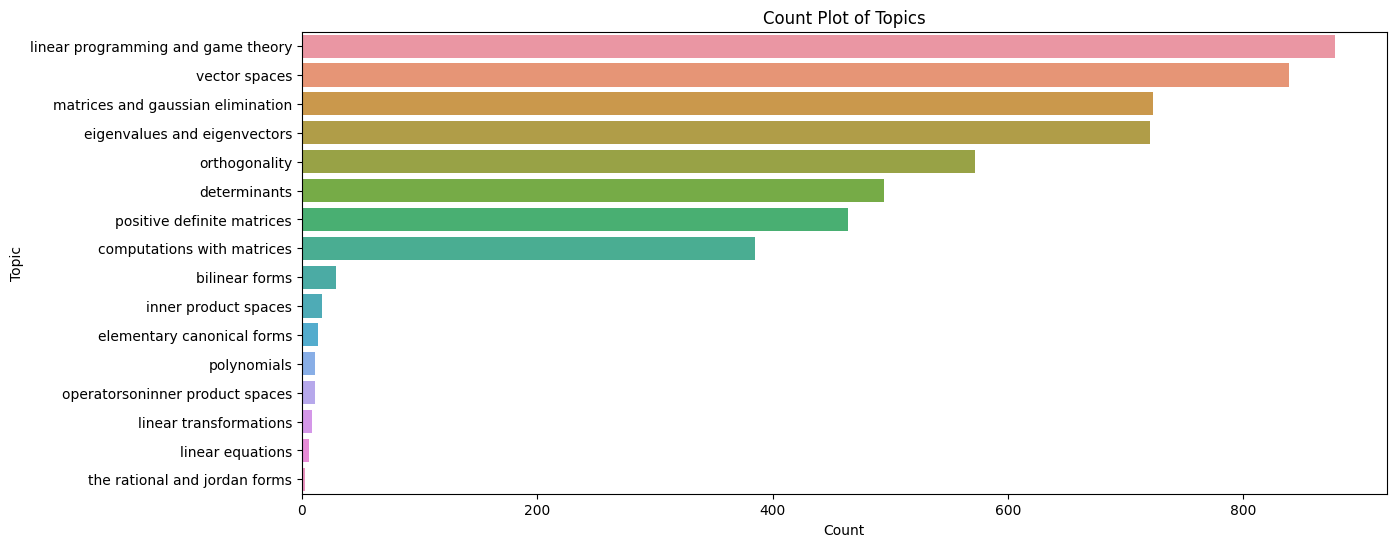

In [4]:
plt.figure(figsize=(14, 6))
sns.countplot(y='Topic', data=data, order=data['Topic'].value_counts().index)
plt.title('Count Plot of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

### Encode the topic labels into numerical values for classification

In [5]:
topic2id = {topic: idx for idx, topic in enumerate(data['Topic'].unique())}
data['label'] = data['Topic'].map(topic2id)

### Create a reverse mapping from label IDs to topic names

In [6]:
id2topic = {v: k for k, v in topic2id.items()}

### Convert text and labels into appropriate data types (String) for processing

In [7]:
data['Question'] = data['Question'].astype(str)
data['label'] = data['label'].astype(int) 

---

# Hyperparameters for fine-tuning

These parameters were chosen based on optimal hyperparameter combination for classification task as determined here [Shen, J.T. et al. (2023) Mathbert: A pre-trained language model for general NLP tasks in mathematics education, arXiv.org.](https://arxiv.org/abs/2106.07340)

In [8]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 16
MAX_SEQ_LEN = 512
EPOCHS = 25

---

# Preparing for fine-tuning

### Split dataset into training and test sets (80-20 split)

In [9]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

### Convert dataset into Hugging Face Dataset format for model training

In [10]:
train_dataset = Dataset.from_dict({
    'text': train_data['Question'].tolist(),
    'label': train_data['label'].tolist()
})
test_dataset = Dataset.from_dict({
    'text': test_data['Question'].tolist(),
    'label': test_data['label'].tolist()
})

In [11]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 4141
})

### Define a function to preprocess text for the model using tokenization

In [12]:
def preprocess_function(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True)

### Define the transformer-based classification model

In [13]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(TransformerClassificationModel, self).__init__()
        
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)

        return {"logits": logits}

### Function to freeze the backbone of the transformer model to fine-tune only the classifier head

In [14]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

    return model

### Define the training loop for fine-tuning the transformer model

In [15]:
def train_transformer(transformer_model, train_loader, val_loader, num_epochs, freeze_backbone=True):
    model = copy.deepcopy(transformer_model)

    if freeze_backbone:
        freeze_backbone_function(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
            for batch in pbar:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                optimizer.zero_grad()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs['logits']
                loss = criterion(logits, labels)

                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

                pbar.set_postfix(loss=loss.item())

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        # Validation step
        model.eval()
        epoch_val_loss = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs['logits']
                loss = criterion(logits, labels)
                epoch_val_loss += loss.item()

                # Convert logits to predicted labels
                preds = torch.argmax(logits, dim=1)

                # Append to lists for metric calculation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate accuracy and F1 score
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'macro' or 'micro' if needed

        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

    # Plotting the training and validation loss
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plotting the accuracy and F1 score
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy and F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model

---

# Finetuning MathBERT

### Load the model

In [16]:
tokenizer_mathbert = BertTokenizer.from_pretrained('tbs17/MathBERT')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

### Convert dataset to required format

In [17]:
mathbert_train = tokenizer_mathbert(
    train_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

mathbert_test = tokenizer_mathbert(
    test_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

In [18]:
mathbert_train_dataset = TensorDataset(mathbert_train['input_ids'], mathbert_train['attention_mask'], torch.tensor(train_dataset['label']))
mathbert_test_dataset = TensorDataset(mathbert_test['input_ids'], mathbert_test['attention_mask'], torch.tensor(test_dataset['label']))

mathbert_train_loader = DataLoader(mathbert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mathbert_test_loader = DataLoader(mathbert_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Finetune with a frozen backbone

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 259/259 [02:03<00:00,  2.10it/s, loss=2.64]


Epoch 1, Training Loss: 2.6409
Epoch 1, Validation Loss: 2.3706, Accuracy: 0.1921, F1 Score: 0.1641


Epoch 2/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=2.44]


Epoch 2, Training Loss: 2.3720
Epoch 2, Validation Loss: 2.1897, Accuracy: 0.2201, F1 Score: 0.1893


Epoch 3/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=2.11]


Epoch 3, Training Loss: 2.2411
Epoch 3, Validation Loss: 2.0965, Accuracy: 0.2510, F1 Score: 0.2134


Epoch 4/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=2.14]


Epoch 4, Training Loss: 2.1619
Epoch 4, Validation Loss: 2.0347, Accuracy: 0.2703, F1 Score: 0.2285


Epoch 5/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=2.2]


Epoch 5, Training Loss: 2.1028
Epoch 5, Validation Loss: 1.9853, Accuracy: 0.3021, F1 Score: 0.2547


Epoch 6/25: 100%|██████████| 259/259 [02:14<00:00,  1.92it/s, loss=2.1]


Epoch 6, Training Loss: 2.0616
Epoch 6, Validation Loss: 1.9459, Accuracy: 0.3243, F1 Score: 0.2737


Epoch 7/25: 100%|██████████| 259/259 [02:15<00:00,  1.90it/s, loss=1.97]


Epoch 7, Training Loss: 2.0238
Epoch 7, Validation Loss: 1.9117, Accuracy: 0.3340, F1 Score: 0.2835


Epoch 8/25: 100%|██████████| 259/259 [02:16<00:00,  1.90it/s, loss=2.01]


Epoch 8, Training Loss: 1.9869
Epoch 8, Validation Loss: 1.8821, Accuracy: 0.3475, F1 Score: 0.3032


Epoch 9/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.92]


Epoch 9, Training Loss: 1.9690
Epoch 9, Validation Loss: 1.8552, Accuracy: 0.3658, F1 Score: 0.3238


Epoch 10/25: 100%|██████████| 259/259 [02:16<00:00,  1.90it/s, loss=1.79]


Epoch 10, Training Loss: 1.9385
Epoch 10, Validation Loss: 1.8309, Accuracy: 0.3842, F1 Score: 0.3453


Epoch 11/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.67]


Epoch 11, Training Loss: 1.9119
Epoch 11, Validation Loss: 1.8098, Accuracy: 0.3861, F1 Score: 0.3491


Epoch 12/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.76]


Epoch 12, Training Loss: 1.8874
Epoch 12, Validation Loss: 1.7872, Accuracy: 0.4025, F1 Score: 0.3688


Epoch 13/25: 100%|██████████| 259/259 [02:14<00:00,  1.92it/s, loss=1.85]


Epoch 13, Training Loss: 1.8677
Epoch 13, Validation Loss: 1.7683, Accuracy: 0.4093, F1 Score: 0.3774


Epoch 14/25: 100%|██████████| 259/259 [02:15<00:00,  1.92it/s, loss=1.73]


Epoch 14, Training Loss: 1.8446
Epoch 14, Validation Loss: 1.7488, Accuracy: 0.4102, F1 Score: 0.3790


Epoch 15/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.91]


Epoch 15, Training Loss: 1.8248
Epoch 15, Validation Loss: 1.7310, Accuracy: 0.4170, F1 Score: 0.3871


Epoch 16/25: 100%|██████████| 259/259 [02:16<00:00,  1.90it/s, loss=1.7]


Epoch 16, Training Loss: 1.8107
Epoch 16, Validation Loss: 1.7154, Accuracy: 0.4237, F1 Score: 0.3951


Epoch 17/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.6]


Epoch 17, Training Loss: 1.7935
Epoch 17, Validation Loss: 1.6982, Accuracy: 0.4315, F1 Score: 0.4060


Epoch 18/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.56]


Epoch 18, Training Loss: 1.7732
Epoch 18, Validation Loss: 1.6829, Accuracy: 0.4411, F1 Score: 0.4146


Epoch 19/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.52]


Epoch 19, Training Loss: 1.7688
Epoch 19, Validation Loss: 1.6692, Accuracy: 0.4450, F1 Score: 0.4200


Epoch 20/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.38]


Epoch 20, Training Loss: 1.7497
Epoch 20, Validation Loss: 1.6553, Accuracy: 0.4537, F1 Score: 0.4293


Epoch 21/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.69]


Epoch 21, Training Loss: 1.7349
Epoch 21, Validation Loss: 1.6412, Accuracy: 0.4624, F1 Score: 0.4389


Epoch 22/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.56]


Epoch 22, Training Loss: 1.7185
Epoch 22, Validation Loss: 1.6269, Accuracy: 0.4701, F1 Score: 0.4454


Epoch 23/25: 100%|██████████| 259/259 [02:16<00:00,  1.90it/s, loss=1.44]


Epoch 23, Training Loss: 1.7098
Epoch 23, Validation Loss: 1.6172, Accuracy: 0.4730, F1 Score: 0.4468


Epoch 24/25: 100%|██████████| 259/259 [02:15<00:00,  1.91it/s, loss=1.95]


Epoch 24, Training Loss: 1.6938
Epoch 24, Validation Loss: 1.6048, Accuracy: 0.4788, F1 Score: 0.4538


Epoch 25/25: 100%|██████████| 259/259 [02:16<00:00,  1.90it/s, loss=1.83]


Epoch 25, Training Loss: 1.6859
Epoch 25, Validation Loss: 1.5921, Accuracy: 0.4788, F1 Score: 0.4543


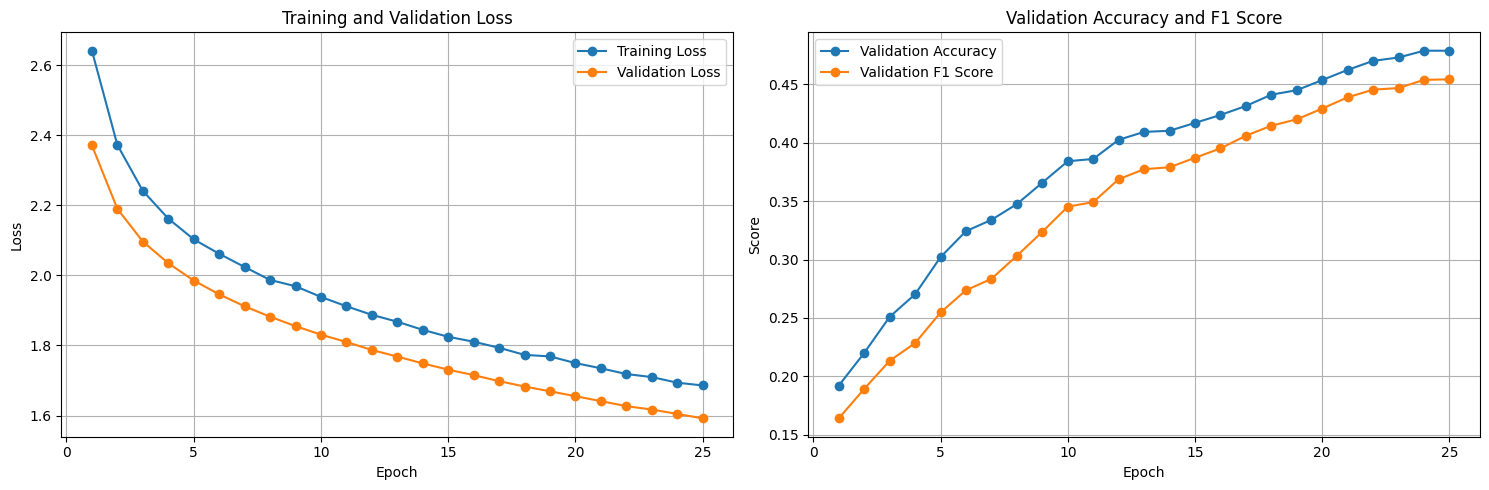

In [19]:
mathbert_transformer_model = TransformerClassificationModel('tbs17/MathBERT', num_classes=len(topic2id))
mathbert_finetuned_with_freezed_backbone = train_transformer(mathbert_transformer_model, mathbert_train_loader, mathbert_test_loader, num_epochs=EPOCHS, freeze_backbone=True)

### Finetune without a frozen backbone

Epoch 1/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=1.44]


Epoch 1, Training Loss: 1.3320
Epoch 1, Validation Loss: 0.7275, Accuracy: 0.7751, F1 Score: 0.7743


Epoch 2/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.14]


Epoch 2, Training Loss: 0.5504
Epoch 2, Validation Loss: 0.5249, Accuracy: 0.8388, F1 Score: 0.8368


Epoch 3/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.281]


Epoch 3, Training Loss: 0.2948
Epoch 3, Validation Loss: 0.4637, Accuracy: 0.8610, F1 Score: 0.8600


Epoch 4/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0343]


Epoch 4, Training Loss: 0.1398
Epoch 4, Validation Loss: 0.4360, Accuracy: 0.8813, F1 Score: 0.8806


Epoch 5/25: 100%|██████████| 259/259 [06:47<00:00,  1.57s/it, loss=0.107]


Epoch 5, Training Loss: 0.0768
Epoch 5, Validation Loss: 0.4727, Accuracy: 0.8822, F1 Score: 0.8822


Epoch 6/25: 100%|██████████| 259/259 [06:47<00:00,  1.57s/it, loss=0.117]


Epoch 6, Training Loss: 0.0518
Epoch 6, Validation Loss: 0.4595, Accuracy: 0.8851, F1 Score: 0.8859


Epoch 7/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00984]


Epoch 7, Training Loss: 0.0377
Epoch 7, Validation Loss: 0.4583, Accuracy: 0.8977, F1 Score: 0.8971


Epoch 8/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0593]


Epoch 8, Training Loss: 0.0328
Epoch 8, Validation Loss: 0.4984, Accuracy: 0.8842, F1 Score: 0.8843


Epoch 9/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0368]


Epoch 9, Training Loss: 0.0247
Epoch 9, Validation Loss: 0.4679, Accuracy: 0.8986, F1 Score: 0.8978


Epoch 10/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0248]


Epoch 10, Training Loss: 0.0209
Epoch 10, Validation Loss: 0.4930, Accuracy: 0.8958, F1 Score: 0.8956


Epoch 11/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.000644]


Epoch 11, Training Loss: 0.0186
Epoch 11, Validation Loss: 0.5373, Accuracy: 0.8880, F1 Score: 0.8883


Epoch 12/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0315]


Epoch 12, Training Loss: 0.0161
Epoch 12, Validation Loss: 0.5106, Accuracy: 0.8958, F1 Score: 0.8955


Epoch 13/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.018]


Epoch 13, Training Loss: 0.0125
Epoch 13, Validation Loss: 0.5522, Accuracy: 0.8958, F1 Score: 0.8947


Epoch 14/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00243]


Epoch 14, Training Loss: 0.0185
Epoch 14, Validation Loss: 0.5800, Accuracy: 0.8745, F1 Score: 0.8732


Epoch 15/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00227]


Epoch 15, Training Loss: 0.0327
Epoch 15, Validation Loss: 0.5268, Accuracy: 0.8900, F1 Score: 0.8894


Epoch 16/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00471]


Epoch 16, Training Loss: 0.0130
Epoch 16, Validation Loss: 0.5647, Accuracy: 0.8842, F1 Score: 0.8838


Epoch 17/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00553]


Epoch 17, Training Loss: 0.0119
Epoch 17, Validation Loss: 0.5743, Accuracy: 0.8967, F1 Score: 0.8962


Epoch 18/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00162]


Epoch 18, Training Loss: 0.0173
Epoch 18, Validation Loss: 0.5730, Accuracy: 0.8938, F1 Score: 0.8930


Epoch 19/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.00169]


Epoch 19, Training Loss: 0.0352
Epoch 19, Validation Loss: 0.5283, Accuracy: 0.8909, F1 Score: 0.8902


Epoch 20/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.0592]


Epoch 20, Training Loss: 0.0212
Epoch 20, Validation Loss: 0.6190, Accuracy: 0.8803, F1 Score: 0.8801


Epoch 21/25: 100%|██████████| 259/259 [06:47<00:00,  1.57s/it, loss=0.00167]


Epoch 21, Training Loss: 0.0085
Epoch 21, Validation Loss: 0.5724, Accuracy: 0.8909, F1 Score: 0.8903


Epoch 22/25: 100%|██████████| 259/259 [06:47<00:00,  1.57s/it, loss=0.00024]


Epoch 22, Training Loss: 0.0067
Epoch 22, Validation Loss: 0.5894, Accuracy: 0.8958, F1 Score: 0.8955


Epoch 23/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.000491]


Epoch 23, Training Loss: 0.0074
Epoch 23, Validation Loss: 0.5861, Accuracy: 0.8938, F1 Score: 0.8937


Epoch 24/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.000759]


Epoch 24, Training Loss: 0.0078
Epoch 24, Validation Loss: 0.6000, Accuracy: 0.8958, F1 Score: 0.8958


Epoch 25/25: 100%|██████████| 259/259 [06:46<00:00,  1.57s/it, loss=0.000269]


Epoch 25, Training Loss: 0.0123
Epoch 25, Validation Loss: 0.6103, Accuracy: 0.8929, F1 Score: 0.8923


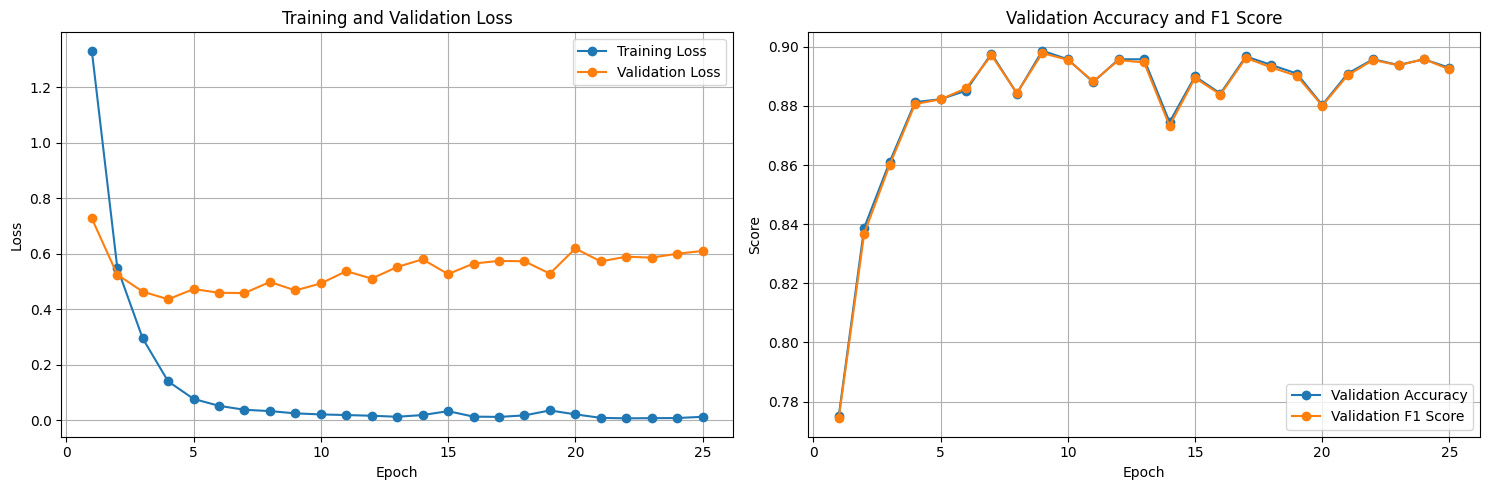

In [20]:
mathbert_transformer_model = TransformerClassificationModel('tbs17/MathBERT', num_classes=len(topic2id))
mathbert_full_finetuned = train_transformer(mathbert_transformer_model, mathbert_train_loader, mathbert_test_loader, num_epochs=EPOCHS, freeze_backbone=False)

4 epochs best

---

# Comparing performance with bert-base-uncased

In [21]:
tokenizer_bert_base = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Convert dataset to required format

In [22]:
bert_base_train = tokenizer_bert_base(
    train_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

bert_base_test = tokenizer_bert_base(
    test_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

In [23]:
bert_base_train_dataset = TensorDataset(bert_base_train['input_ids'], bert_base_train['attention_mask'], torch.tensor(train_dataset['label']))
bert_base_test_dataset = TensorDataset(bert_base_test['input_ids'], bert_base_test['attention_mask'], torch.tensor(test_dataset['label']))

bert_base_train_loader = DataLoader(bert_base_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bert_base_test_loader = DataLoader(bert_base_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Finetune with a frozen backbone

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 259/259 [02:28<00:00,  1.75it/s, loss=2.6]


Epoch 1, Training Loss: 2.6943
Epoch 1, Validation Loss: 2.5053, Accuracy: 0.1544, F1 Score: 0.1174


Epoch 2/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.43]


Epoch 2, Training Loss: 2.4345
Epoch 2, Validation Loss: 2.3091, Accuracy: 0.1863, F1 Score: 0.1531


Epoch 3/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.14]


Epoch 3, Training Loss: 2.2904
Epoch 3, Validation Loss: 2.2009, Accuracy: 0.1998, F1 Score: 0.1624


Epoch 4/25: 100%|██████████| 259/259 [02:26<00:00,  1.76it/s, loss=2.17]


Epoch 4, Training Loss: 2.2101
Epoch 4, Validation Loss: 2.1348, Accuracy: 0.2384, F1 Score: 0.1902


Epoch 5/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.04]


Epoch 5, Training Loss: 2.1527
Epoch 5, Validation Loss: 2.0875, Accuracy: 0.2693, F1 Score: 0.2089


Epoch 6/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.11]


Epoch 6, Training Loss: 2.1143
Epoch 6, Validation Loss: 2.0513, Accuracy: 0.2896, F1 Score: 0.2388


Epoch 7/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.28]


Epoch 7, Training Loss: 2.0785
Epoch 7, Validation Loss: 2.0218, Accuracy: 0.3041, F1 Score: 0.2570


Epoch 8/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.87]


Epoch 8, Training Loss: 2.0533
Epoch 8, Validation Loss: 1.9956, Accuracy: 0.3166, F1 Score: 0.2730


Epoch 9/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.48]


Epoch 9, Training Loss: 2.0296
Epoch 9, Validation Loss: 1.9731, Accuracy: 0.3320, F1 Score: 0.2930


Epoch 10/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.07]


Epoch 10, Training Loss: 2.0138
Epoch 10, Validation Loss: 1.9532, Accuracy: 0.3542, F1 Score: 0.3184


Epoch 11/25: 100%|██████████| 259/259 [02:26<00:00,  1.76it/s, loss=1.98]


Epoch 11, Training Loss: 1.9893
Epoch 11, Validation Loss: 1.9350, Accuracy: 0.3649, F1 Score: 0.3290


Epoch 12/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.91]


Epoch 12, Training Loss: 1.9762
Epoch 12, Validation Loss: 1.9193, Accuracy: 0.3803, F1 Score: 0.3488


Epoch 13/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.93]


Epoch 13, Training Loss: 1.9580
Epoch 13, Validation Loss: 1.9036, Accuracy: 0.3851, F1 Score: 0.3544


Epoch 14/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.09]


Epoch 14, Training Loss: 1.9424
Epoch 14, Validation Loss: 1.8890, Accuracy: 0.3890, F1 Score: 0.3604


Epoch 15/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.81]


Epoch 15, Training Loss: 1.9303
Epoch 15, Validation Loss: 1.8760, Accuracy: 0.3929, F1 Score: 0.3671


Epoch 16/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.73]


Epoch 16, Training Loss: 1.9173
Epoch 16, Validation Loss: 1.8636, Accuracy: 0.3929, F1 Score: 0.3666


Epoch 17/25: 100%|██████████| 259/259 [02:27<00:00,  1.76it/s, loss=1.78]


Epoch 17, Training Loss: 1.9063
Epoch 17, Validation Loss: 1.8509, Accuracy: 0.4006, F1 Score: 0.3797


Epoch 18/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.1]


Epoch 18, Training Loss: 1.8933
Epoch 18, Validation Loss: 1.8399, Accuracy: 0.3996, F1 Score: 0.3773


Epoch 19/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.44]


Epoch 19, Training Loss: 1.8842
Epoch 19, Validation Loss: 1.8290, Accuracy: 0.4093, F1 Score: 0.3887


Epoch 20/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.23]


Epoch 20, Training Loss: 1.8743
Epoch 20, Validation Loss: 1.8212, Accuracy: 0.4131, F1 Score: 0.3947


Epoch 21/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=2.21]


Epoch 21, Training Loss: 1.8620
Epoch 21, Validation Loss: 1.8105, Accuracy: 0.4141, F1 Score: 0.3965


Epoch 22/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.46]


Epoch 22, Training Loss: 1.8507
Epoch 22, Validation Loss: 1.8016, Accuracy: 0.4151, F1 Score: 0.3989


Epoch 23/25: 100%|██████████| 259/259 [02:26<00:00,  1.76it/s, loss=1.42]


Epoch 23, Training Loss: 1.8440
Epoch 23, Validation Loss: 1.7930, Accuracy: 0.4199, F1 Score: 0.4034


Epoch 24/25: 100%|██████████| 259/259 [02:26<00:00,  1.76it/s, loss=1.66]


Epoch 24, Training Loss: 1.8373
Epoch 24, Validation Loss: 1.7839, Accuracy: 0.4180, F1 Score: 0.4014


Epoch 25/25: 100%|██████████| 259/259 [02:26<00:00,  1.77it/s, loss=1.52]


Epoch 25, Training Loss: 1.8230
Epoch 25, Validation Loss: 1.7754, Accuracy: 0.4266, F1 Score: 0.4107


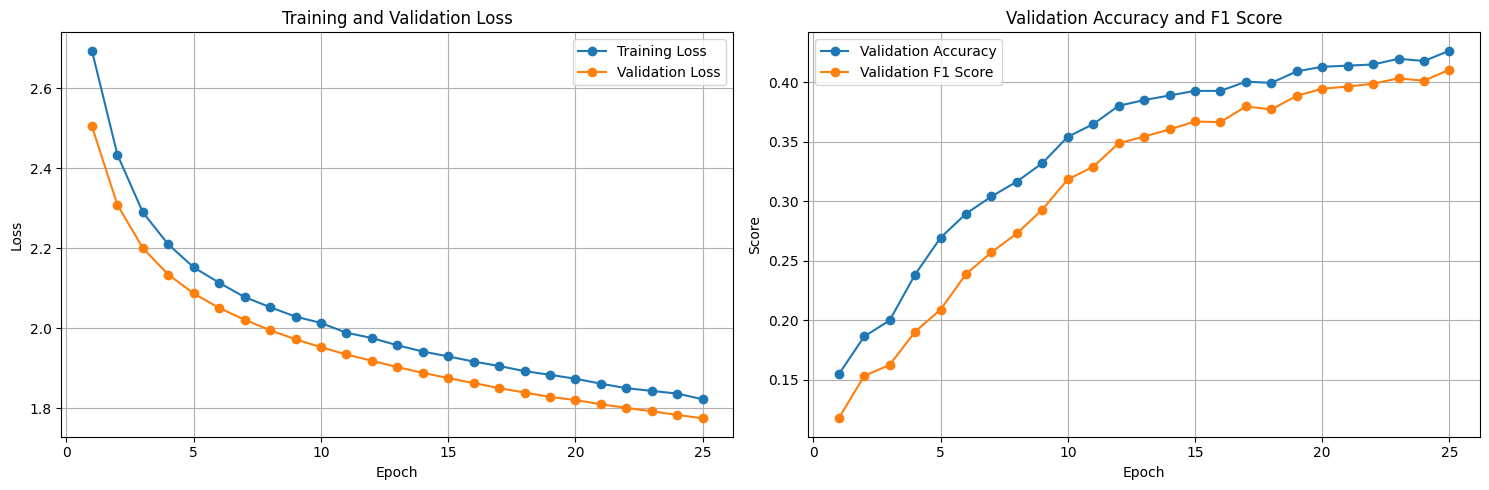

In [24]:
bert_base_transformer_model = TransformerClassificationModel('google-bert/bert-base-uncased', num_classes=len(topic2id))
bert_finetuned_with_freezed_backbone = train_transformer(bert_base_transformer_model, bert_base_train_loader, bert_base_test_loader, num_epochs=EPOCHS, freeze_backbone=True)

### Finetune without a frozen backbone

Epoch 1/25: 100%|██████████| 259/259 [06:50<00:00,  1.59s/it, loss=0.912]


Epoch 1, Training Loss: 1.5772
Epoch 1, Validation Loss: 0.8903, Accuracy: 0.7529, F1 Score: 0.7496


Epoch 2/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=1.56]


Epoch 2, Training Loss: 0.7305
Epoch 2, Validation Loss: 0.6289, Accuracy: 0.8098, F1 Score: 0.8082


Epoch 3/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.491]


Epoch 3, Training Loss: 0.4361
Epoch 3, Validation Loss: 0.4912, Accuracy: 0.8591, F1 Score: 0.8562


Epoch 4/25: 100%|██████████| 259/259 [06:50<00:00,  1.58s/it, loss=0.0784]


Epoch 4, Training Loss: 0.2830
Epoch 4, Validation Loss: 0.4412, Accuracy: 0.8726, F1 Score: 0.8709


Epoch 5/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0487]


Epoch 5, Training Loss: 0.1736
Epoch 5, Validation Loss: 0.4334, Accuracy: 0.8842, F1 Score: 0.8824


Epoch 6/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.228]


Epoch 6, Training Loss: 0.1157
Epoch 6, Validation Loss: 0.4317, Accuracy: 0.8900, F1 Score: 0.8894


Epoch 7/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0296]


Epoch 7, Training Loss: 0.0872
Epoch 7, Validation Loss: 0.4482, Accuracy: 0.8909, F1 Score: 0.8897


Epoch 8/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00897]


Epoch 8, Training Loss: 0.0656
Epoch 8, Validation Loss: 0.4555, Accuracy: 0.8871, F1 Score: 0.8861


Epoch 9/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0463]


Epoch 9, Training Loss: 0.0502
Epoch 9, Validation Loss: 0.4734, Accuracy: 0.8909, F1 Score: 0.8905


Epoch 10/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0183]


Epoch 10, Training Loss: 0.0393
Epoch 10, Validation Loss: 0.4829, Accuracy: 0.8784, F1 Score: 0.8787


Epoch 11/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0496]


Epoch 11, Training Loss: 0.0419
Epoch 11, Validation Loss: 0.4486, Accuracy: 0.8938, F1 Score: 0.8932


Epoch 12/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0972]


Epoch 12, Training Loss: 0.0289
Epoch 12, Validation Loss: 0.4802, Accuracy: 0.8919, F1 Score: 0.8910


Epoch 13/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0048]


Epoch 13, Training Loss: 0.0251
Epoch 13, Validation Loss: 0.4495, Accuracy: 0.9006, F1 Score: 0.9001


Epoch 14/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00489]


Epoch 14, Training Loss: 0.0252
Epoch 14, Validation Loss: 0.5009, Accuracy: 0.8909, F1 Score: 0.8907


Epoch 15/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0235]


Epoch 15, Training Loss: 0.0369
Epoch 15, Validation Loss: 0.5277, Accuracy: 0.8842, F1 Score: 0.8833


Epoch 16/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00716]


Epoch 16, Training Loss: 0.0267
Epoch 16, Validation Loss: 0.5707, Accuracy: 0.8793, F1 Score: 0.8790


Epoch 17/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0079]


Epoch 17, Training Loss: 0.0168
Epoch 17, Validation Loss: 0.5496, Accuracy: 0.8880, F1 Score: 0.8883


Epoch 18/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00794]


Epoch 18, Training Loss: 0.0260
Epoch 18, Validation Loss: 0.5556, Accuracy: 0.8909, F1 Score: 0.8908


Epoch 19/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.192]


Epoch 19, Training Loss: 0.0221
Epoch 19, Validation Loss: 0.5051, Accuracy: 0.8938, F1 Score: 0.8934


Epoch 20/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00251]


Epoch 20, Training Loss: 0.0144
Epoch 20, Validation Loss: 0.5310, Accuracy: 0.8958, F1 Score: 0.8952


Epoch 21/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00503]


Epoch 21, Training Loss: 0.0113
Epoch 21, Validation Loss: 0.5562, Accuracy: 0.8948, F1 Score: 0.8945


Epoch 22/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0268]


Epoch 22, Training Loss: 0.0233
Epoch 22, Validation Loss: 0.5877, Accuracy: 0.8851, F1 Score: 0.8838


Epoch 23/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00335]


Epoch 23, Training Loss: 0.0190
Epoch 23, Validation Loss: 0.5977, Accuracy: 0.8929, F1 Score: 0.8922


Epoch 24/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.0011]


Epoch 24, Training Loss: 0.0220
Epoch 24, Validation Loss: 0.5268, Accuracy: 0.8977, F1 Score: 0.8969


Epoch 25/25: 100%|██████████| 259/259 [06:49<00:00,  1.58s/it, loss=0.00193]


Epoch 25, Training Loss: 0.0167
Epoch 25, Validation Loss: 0.5350, Accuracy: 0.8900, F1 Score: 0.8891


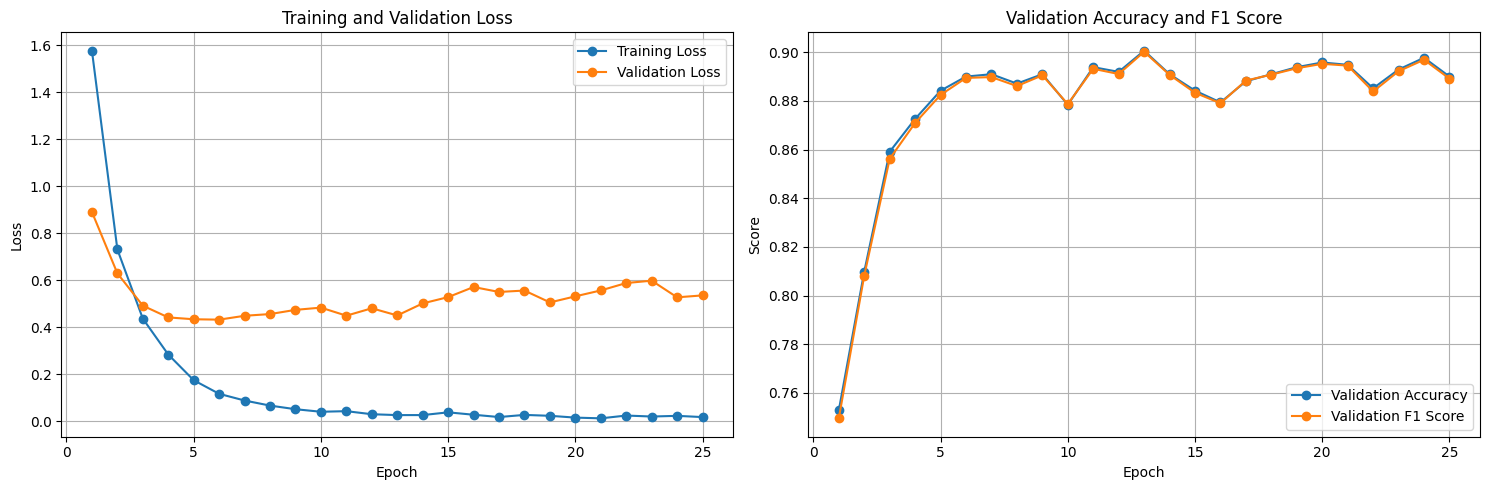

In [25]:
bert_base_transformer_model = TransformerClassificationModel('google-bert/bert-base-uncased', num_classes=len(topic2id))
bert_base_full_finetuned = train_transformer(bert_base_transformer_model, bert_base_train_loader, bert_base_test_loader, num_epochs=EPOCHS, freeze_backbone=False)

---

# Comparing performance with bert-tiny

In [26]:
tokenizer_bert_tiny = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

### Convert dataset to required format

In [27]:
bert_tiny_train = tokenizer_bert_tiny(
    train_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

bert_tiny_test = tokenizer_bert_tiny(
    test_dataset['text'], padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt"
)

In [28]:
bert_tiny_train_dataset = TensorDataset(bert_tiny_train['input_ids'], bert_tiny_train['attention_mask'], torch.tensor(train_dataset['label']))
bert_tiny_test_dataset = TensorDataset(bert_tiny_test['input_ids'], bert_tiny_test['attention_mask'], torch.tensor(test_dataset['label']))

bert_tiny_train_loader = DataLoader(bert_tiny_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bert_tiny_test_loader = DataLoader(bert_tiny_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Finetune with a frozen backbone

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Epoch 1/50: 100%|██████████| 259/259 [00:02<00:00, 127.53it/s, loss=2.93]


Epoch 1, Training Loss: 2.7175
Epoch 1, Validation Loss: 2.6441, Accuracy: 0.0695, F1 Score: 0.0499


Epoch 2/50: 100%|██████████| 259/259 [00:01<00:00, 133.16it/s, loss=2.65]


Epoch 2, Training Loss: 2.6097
Epoch 2, Validation Loss: 2.5310, Accuracy: 0.1062, F1 Score: 0.0701


Epoch 3/50: 100%|██████████| 259/259 [00:01<00:00, 131.65it/s, loss=2.49]


Epoch 3, Training Loss: 2.5090
Epoch 3, Validation Loss: 2.4403, Accuracy: 0.1525, F1 Score: 0.0956


Epoch 4/50: 100%|██████████| 259/259 [00:01<00:00, 129.89it/s, loss=2.53]


Epoch 4, Training Loss: 2.4303
Epoch 4, Validation Loss: 2.3656, Accuracy: 0.1757, F1 Score: 0.1120


Epoch 5/50: 100%|██████████| 259/259 [00:01<00:00, 130.24it/s, loss=2.36]


Epoch 5, Training Loss: 2.3712
Epoch 5, Validation Loss: 2.3062, Accuracy: 0.1863, F1 Score: 0.1220


Epoch 6/50: 100%|██████████| 259/259 [00:01<00:00, 130.14it/s, loss=2.43]


Epoch 6, Training Loss: 2.3221
Epoch 6, Validation Loss: 2.2559, Accuracy: 0.1873, F1 Score: 0.1263


Epoch 7/50: 100%|██████████| 259/259 [00:01<00:00, 129.93it/s, loss=2.25]


Epoch 7, Training Loss: 2.2734
Epoch 7, Validation Loss: 2.2146, Accuracy: 0.1998, F1 Score: 0.1410


Epoch 8/50: 100%|██████████| 259/259 [00:02<00:00, 129.34it/s, loss=2.14]


Epoch 8, Training Loss: 2.2482
Epoch 8, Validation Loss: 2.1794, Accuracy: 0.2056, F1 Score: 0.1497


Epoch 9/50: 100%|██████████| 259/259 [00:02<00:00, 128.48it/s, loss=2.19]


Epoch 9, Training Loss: 2.2091
Epoch 9, Validation Loss: 2.1499, Accuracy: 0.2133, F1 Score: 0.1610


Epoch 10/50: 100%|██████████| 259/259 [00:02<00:00, 127.81it/s, loss=2.27]


Epoch 10, Training Loss: 2.1831
Epoch 10, Validation Loss: 2.1241, Accuracy: 0.2220, F1 Score: 0.1695


Epoch 11/50: 100%|██████████| 259/259 [00:02<00:00, 127.15it/s, loss=2.29]


Epoch 11, Training Loss: 2.1643
Epoch 11, Validation Loss: 2.1011, Accuracy: 0.2307, F1 Score: 0.1803


Epoch 12/50: 100%|██████████| 259/259 [00:02<00:00, 126.80it/s, loss=1.89]


Epoch 12, Training Loss: 2.1453
Epoch 12, Validation Loss: 2.0828, Accuracy: 0.2375, F1 Score: 0.1893


Epoch 13/50: 100%|██████████| 259/259 [00:02<00:00, 126.70it/s, loss=2.25]


Epoch 13, Training Loss: 2.1289
Epoch 13, Validation Loss: 2.0647, Accuracy: 0.2384, F1 Score: 0.1937


Epoch 14/50: 100%|██████████| 259/259 [00:02<00:00, 126.59it/s, loss=1.96]


Epoch 14, Training Loss: 2.1119
Epoch 14, Validation Loss: 2.0488, Accuracy: 0.2442, F1 Score: 0.1997


Epoch 15/50: 100%|██████████| 259/259 [00:02<00:00, 128.13it/s, loss=2.33]


Epoch 15, Training Loss: 2.0916
Epoch 15, Validation Loss: 2.0347, Accuracy: 0.2539, F1 Score: 0.2100


Epoch 16/50: 100%|██████████| 259/259 [00:02<00:00, 128.16it/s, loss=2.2]


Epoch 16, Training Loss: 2.0823
Epoch 16, Validation Loss: 2.0217, Accuracy: 0.2597, F1 Score: 0.2189


Epoch 17/50: 100%|██████████| 259/259 [00:02<00:00, 127.96it/s, loss=1.97]


Epoch 17, Training Loss: 2.0698
Epoch 17, Validation Loss: 2.0098, Accuracy: 0.2654, F1 Score: 0.2282


Epoch 18/50: 100%|██████████| 259/259 [00:01<00:00, 129.97it/s, loss=2.04]


Epoch 18, Training Loss: 2.0558
Epoch 18, Validation Loss: 1.9992, Accuracy: 0.2693, F1 Score: 0.2325


Epoch 19/50: 100%|██████████| 259/259 [00:01<00:00, 130.54it/s, loss=2.55]


Epoch 19, Training Loss: 2.0487
Epoch 19, Validation Loss: 1.9888, Accuracy: 0.2674, F1 Score: 0.2313


Epoch 20/50: 100%|██████████| 259/259 [00:01<00:00, 130.90it/s, loss=1.99]


Epoch 20, Training Loss: 2.0427
Epoch 20, Validation Loss: 1.9782, Accuracy: 0.2761, F1 Score: 0.2412


Epoch 21/50: 100%|██████████| 259/259 [00:01<00:00, 131.65it/s, loss=2.23]


Epoch 21, Training Loss: 2.0364
Epoch 21, Validation Loss: 1.9693, Accuracy: 0.2847, F1 Score: 0.2509


Epoch 22/50: 100%|██████████| 259/259 [00:01<00:00, 131.31it/s, loss=2.06]


Epoch 22, Training Loss: 2.0219
Epoch 22, Validation Loss: 1.9598, Accuracy: 0.2925, F1 Score: 0.2599


Epoch 23/50: 100%|██████████| 259/259 [00:01<00:00, 131.51it/s, loss=2.14]


Epoch 23, Training Loss: 2.0150
Epoch 23, Validation Loss: 1.9516, Accuracy: 0.2944, F1 Score: 0.2640


Epoch 24/50: 100%|██████████| 259/259 [00:01<00:00, 132.06it/s, loss=2.14]


Epoch 24, Training Loss: 2.0038
Epoch 24, Validation Loss: 1.9442, Accuracy: 0.3021, F1 Score: 0.2740


Epoch 25/50: 100%|██████████| 259/259 [00:01<00:00, 132.46it/s, loss=1.71]


Epoch 25, Training Loss: 1.9956
Epoch 25, Validation Loss: 1.9365, Accuracy: 0.3079, F1 Score: 0.2813


Epoch 26/50: 100%|██████████| 259/259 [00:01<00:00, 132.17it/s, loss=2.11]


Epoch 26, Training Loss: 1.9912
Epoch 26, Validation Loss: 1.9289, Accuracy: 0.3108, F1 Score: 0.2854


Epoch 27/50: 100%|██████████| 259/259 [00:01<00:00, 133.27it/s, loss=1.82]


Epoch 27, Training Loss: 1.9809
Epoch 27, Validation Loss: 1.9215, Accuracy: 0.3127, F1 Score: 0.2875


Epoch 28/50: 100%|██████████| 259/259 [00:01<00:00, 131.96it/s, loss=1.9]


Epoch 28, Training Loss: 1.9752
Epoch 28, Validation Loss: 1.9144, Accuracy: 0.3156, F1 Score: 0.2913


Epoch 29/50: 100%|██████████| 259/259 [00:01<00:00, 133.19it/s, loss=1.8]


Epoch 29, Training Loss: 1.9716
Epoch 29, Validation Loss: 1.9094, Accuracy: 0.3195, F1 Score: 0.2956


Epoch 30/50: 100%|██████████| 259/259 [00:01<00:00, 130.50it/s, loss=2.05]


Epoch 30, Training Loss: 1.9668
Epoch 30, Validation Loss: 1.9043, Accuracy: 0.3243, F1 Score: 0.3011


Epoch 31/50: 100%|██████████| 259/259 [00:01<00:00, 133.42it/s, loss=1.95]


Epoch 31, Training Loss: 1.9582
Epoch 31, Validation Loss: 1.8971, Accuracy: 0.3234, F1 Score: 0.3002


Epoch 32/50: 100%|██████████| 259/259 [00:01<00:00, 132.71it/s, loss=2.23]


Epoch 32, Training Loss: 1.9563
Epoch 32, Validation Loss: 1.8916, Accuracy: 0.3243, F1 Score: 0.3018


Epoch 33/50: 100%|██████████| 259/259 [00:01<00:00, 132.67it/s, loss=1.61]


Epoch 33, Training Loss: 1.9460
Epoch 33, Validation Loss: 1.8863, Accuracy: 0.3243, F1 Score: 0.3024


Epoch 34/50: 100%|██████████| 259/259 [00:01<00:00, 132.27it/s, loss=2.08]


Epoch 34, Training Loss: 1.9487
Epoch 34, Validation Loss: 1.8812, Accuracy: 0.3263, F1 Score: 0.3051


Epoch 35/50: 100%|██████████| 259/259 [00:01<00:00, 132.56it/s, loss=1.85]


Epoch 35, Training Loss: 1.9370
Epoch 35, Validation Loss: 1.8748, Accuracy: 0.3292, F1 Score: 0.3090


Epoch 36/50: 100%|██████████| 259/259 [00:01<00:00, 132.48it/s, loss=2.28]


Epoch 36, Training Loss: 1.9390
Epoch 36, Validation Loss: 1.8707, Accuracy: 0.3340, F1 Score: 0.3136


Epoch 37/50: 100%|██████████| 259/259 [00:01<00:00, 132.15it/s, loss=1.88]


Epoch 37, Training Loss: 1.9312
Epoch 37, Validation Loss: 1.8655, Accuracy: 0.3369, F1 Score: 0.3174


Epoch 38/50: 100%|██████████| 259/259 [00:01<00:00, 132.17it/s, loss=1.65]


Epoch 38, Training Loss: 1.9234
Epoch 38, Validation Loss: 1.8608, Accuracy: 0.3436, F1 Score: 0.3259


Epoch 39/50: 100%|██████████| 259/259 [00:01<00:00, 131.63it/s, loss=2.26]


Epoch 39, Training Loss: 1.9174
Epoch 39, Validation Loss: 1.8571, Accuracy: 0.3446, F1 Score: 0.3278


Epoch 40/50: 100%|██████████| 259/259 [00:01<00:00, 130.96it/s, loss=1.91]


Epoch 40, Training Loss: 1.9151
Epoch 40, Validation Loss: 1.8507, Accuracy: 0.3456, F1 Score: 0.3289


Epoch 41/50: 100%|██████████| 259/259 [00:01<00:00, 130.58it/s, loss=1.78]


Epoch 41, Training Loss: 1.9050
Epoch 41, Validation Loss: 1.8486, Accuracy: 0.3446, F1 Score: 0.3289


Epoch 42/50: 100%|██████████| 259/259 [00:01<00:00, 129.97it/s, loss=1.54]


Epoch 42, Training Loss: 1.9077
Epoch 42, Validation Loss: 1.8435, Accuracy: 0.3475, F1 Score: 0.3320


Epoch 43/50: 100%|██████████| 259/259 [00:02<00:00, 128.96it/s, loss=1.79]


Epoch 43, Training Loss: 1.9022
Epoch 43, Validation Loss: 1.8391, Accuracy: 0.3485, F1 Score: 0.3328


Epoch 44/50: 100%|██████████| 259/259 [00:01<00:00, 129.90it/s, loss=2.32]


Epoch 44, Training Loss: 1.9008
Epoch 44, Validation Loss: 1.8370, Accuracy: 0.3542, F1 Score: 0.3383


Epoch 45/50: 100%|██████████| 259/259 [00:01<00:00, 130.07it/s, loss=1.72]


Epoch 45, Training Loss: 1.8922
Epoch 45, Validation Loss: 1.8307, Accuracy: 0.3562, F1 Score: 0.3406


Epoch 46/50: 100%|██████████| 259/259 [00:01<00:00, 130.19it/s, loss=1.86]


Epoch 46, Training Loss: 1.8902
Epoch 46, Validation Loss: 1.8276, Accuracy: 0.3610, F1 Score: 0.3459


Epoch 47/50: 100%|██████████| 259/259 [00:01<00:00, 129.71it/s, loss=1.55]


Epoch 47, Training Loss: 1.8852
Epoch 47, Validation Loss: 1.8230, Accuracy: 0.3600, F1 Score: 0.3457


Epoch 48/50: 100%|██████████| 259/259 [00:01<00:00, 129.83it/s, loss=1.9]


Epoch 48, Training Loss: 1.8849
Epoch 48, Validation Loss: 1.8192, Accuracy: 0.3639, F1 Score: 0.3498


Epoch 49/50: 100%|██████████| 259/259 [00:01<00:00, 130.38it/s, loss=2.27]


Epoch 49, Training Loss: 1.8778
Epoch 49, Validation Loss: 1.8156, Accuracy: 0.3639, F1 Score: 0.3496


Epoch 50/50: 100%|██████████| 259/259 [00:01<00:00, 130.30it/s, loss=1.95]


Epoch 50, Training Loss: 1.8768
Epoch 50, Validation Loss: 1.8114, Accuracy: 0.3658, F1 Score: 0.3517


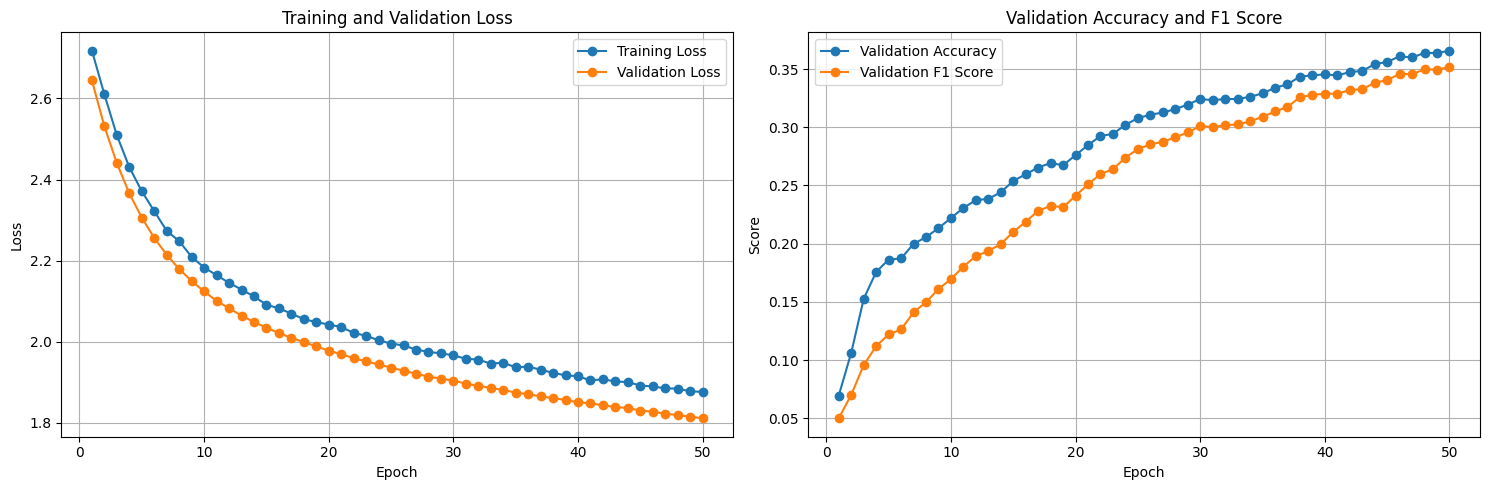

In [29]:
bert_tiny_transformer_model = TransformerClassificationModel('prajjwal1/bert-tiny', num_classes=len(topic2id))
bert_tiny_finetuned_with_freezed_backbone = train_transformer(bert_tiny_transformer_model, bert_tiny_train_loader, bert_tiny_test_loader, num_epochs=2*EPOCHS, freeze_backbone=True)

### Finetune without a frozen backbone

Epoch 1/50: 100%|██████████| 259/259 [00:06<00:00, 42.95it/s, loss=2.16]


Epoch 1, Training Loss: 2.4281
Epoch 1, Validation Loss: 2.0862, Accuracy: 0.2423, F1 Score: 0.1952


Epoch 2/50: 100%|██████████| 259/259 [00:06<00:00, 43.11it/s, loss=1.84]


Epoch 2, Training Loss: 2.0628
Epoch 2, Validation Loss: 1.9054, Accuracy: 0.3156, F1 Score: 0.2815


Epoch 3/50: 100%|██████████| 259/259 [00:06<00:00, 42.60it/s, loss=1.76]


Epoch 3, Training Loss: 1.9263
Epoch 3, Validation Loss: 1.7712, Accuracy: 0.3977, F1 Score: 0.3817


Epoch 4/50: 100%|██████████| 259/259 [00:06<00:00, 42.05it/s, loss=1.9]


Epoch 4, Training Loss: 1.7983
Epoch 4, Validation Loss: 1.6348, Accuracy: 0.4643, F1 Score: 0.4641


Epoch 5/50: 100%|██████████| 259/259 [00:06<00:00, 41.52it/s, loss=1.75]


Epoch 5, Training Loss: 1.6618
Epoch 5, Validation Loss: 1.4901, Accuracy: 0.5280, F1 Score: 0.5331


Epoch 6/50: 100%|██████████| 259/259 [00:06<00:00, 41.95it/s, loss=0.965]


Epoch 6, Training Loss: 1.5424
Epoch 6, Validation Loss: 1.3646, Accuracy: 0.5734, F1 Score: 0.5680


Epoch 7/50: 100%|██████████| 259/259 [00:06<00:00, 42.57it/s, loss=1.19]


Epoch 7, Training Loss: 1.4290
Epoch 7, Validation Loss: 1.2690, Accuracy: 0.6110, F1 Score: 0.6053


Epoch 8/50: 100%|██████████| 259/259 [00:06<00:00, 43.07it/s, loss=1.14]


Epoch 8, Training Loss: 1.3347
Epoch 8, Validation Loss: 1.1827, Accuracy: 0.6207, F1 Score: 0.6169


Epoch 9/50: 100%|██████████| 259/259 [00:05<00:00, 43.39it/s, loss=1.99]


Epoch 9, Training Loss: 1.2555
Epoch 9, Validation Loss: 1.1138, Accuracy: 0.6515, F1 Score: 0.6476


Epoch 10/50: 100%|██████████| 259/259 [00:05<00:00, 43.52it/s, loss=0.975]


Epoch 10, Training Loss: 1.1916
Epoch 10, Validation Loss: 1.0650, Accuracy: 0.6660, F1 Score: 0.6607


Epoch 11/50: 100%|██████████| 259/259 [00:05<00:00, 43.64it/s, loss=1.02]


Epoch 11, Training Loss: 1.1275
Epoch 11, Validation Loss: 1.0115, Accuracy: 0.6786, F1 Score: 0.6751


Epoch 12/50: 100%|██████████| 259/259 [00:05<00:00, 43.69it/s, loss=1.11]


Epoch 12, Training Loss: 1.0716
Epoch 12, Validation Loss: 0.9708, Accuracy: 0.6979, F1 Score: 0.6914


Epoch 13/50: 100%|██████████| 259/259 [00:05<00:00, 43.59it/s, loss=1.13]


Epoch 13, Training Loss: 1.0179
Epoch 13, Validation Loss: 0.9401, Accuracy: 0.6979, F1 Score: 0.6973


Epoch 14/50: 100%|██████████| 259/259 [00:05<00:00, 43.41it/s, loss=0.616]


Epoch 14, Training Loss: 0.9752
Epoch 14, Validation Loss: 0.9070, Accuracy: 0.7095, F1 Score: 0.7047


Epoch 15/50: 100%|██████████| 259/259 [00:06<00:00, 43.15it/s, loss=0.736]


Epoch 15, Training Loss: 0.9300
Epoch 15, Validation Loss: 0.8731, Accuracy: 0.7220, F1 Score: 0.7194


Epoch 16/50: 100%|██████████| 259/259 [00:06<00:00, 43.00it/s, loss=0.664]


Epoch 16, Training Loss: 0.8851
Epoch 16, Validation Loss: 0.8450, Accuracy: 0.7346, F1 Score: 0.7323


Epoch 17/50: 100%|██████████| 259/259 [00:06<00:00, 42.89it/s, loss=0.785]


Epoch 17, Training Loss: 0.8422
Epoch 17, Validation Loss: 0.8211, Accuracy: 0.7423, F1 Score: 0.7381


Epoch 18/50: 100%|██████████| 259/259 [00:06<00:00, 42.78it/s, loss=0.278]


Epoch 18, Training Loss: 0.8024
Epoch 18, Validation Loss: 0.8035, Accuracy: 0.7500, F1 Score: 0.7465


Epoch 19/50: 100%|██████████| 259/259 [00:06<00:00, 42.86it/s, loss=1.11]


Epoch 19, Training Loss: 0.7726
Epoch 19, Validation Loss: 0.7795, Accuracy: 0.7558, F1 Score: 0.7523


Epoch 20/50: 100%|██████████| 259/259 [00:06<00:00, 42.83it/s, loss=0.846]


Epoch 20, Training Loss: 0.7505
Epoch 20, Validation Loss: 0.7528, Accuracy: 0.7674, F1 Score: 0.7636


Epoch 21/50: 100%|██████████| 259/259 [00:06<00:00, 43.04it/s, loss=0.442]


Epoch 21, Training Loss: 0.7082
Epoch 21, Validation Loss: 0.7382, Accuracy: 0.7761, F1 Score: 0.7731


Epoch 22/50: 100%|██████████| 259/259 [00:06<00:00, 43.07it/s, loss=0.426]


Epoch 22, Training Loss: 0.6686
Epoch 22, Validation Loss: 0.7336, Accuracy: 0.7780, F1 Score: 0.7741


Epoch 23/50: 100%|██████████| 259/259 [00:05<00:00, 43.27it/s, loss=0.447]


Epoch 23, Training Loss: 0.6455
Epoch 23, Validation Loss: 0.7150, Accuracy: 0.7838, F1 Score: 0.7808


Epoch 24/50: 100%|██████████| 259/259 [00:05<00:00, 43.37it/s, loss=0.6]


Epoch 24, Training Loss: 0.6215
Epoch 24, Validation Loss: 0.6986, Accuracy: 0.7905, F1 Score: 0.7874


Epoch 25/50: 100%|██████████| 259/259 [00:05<00:00, 43.29it/s, loss=0.586]


Epoch 25, Training Loss: 0.5926
Epoch 25, Validation Loss: 0.6857, Accuracy: 0.7992, F1 Score: 0.7959


Epoch 26/50: 100%|██████████| 259/259 [00:05<00:00, 43.37it/s, loss=1.01]


Epoch 26, Training Loss: 0.5670
Epoch 26, Validation Loss: 0.6781, Accuracy: 0.8012, F1 Score: 0.7979


Epoch 27/50: 100%|██████████| 259/259 [00:05<00:00, 43.21it/s, loss=0.426]


Epoch 27, Training Loss: 0.5512
Epoch 27, Validation Loss: 0.6641, Accuracy: 0.8031, F1 Score: 0.8003


Epoch 28/50: 100%|██████████| 259/259 [00:05<00:00, 43.26it/s, loss=0.242]


Epoch 28, Training Loss: 0.5203
Epoch 28, Validation Loss: 0.6553, Accuracy: 0.8050, F1 Score: 0.8026


Epoch 29/50: 100%|██████████| 259/259 [00:05<00:00, 43.21it/s, loss=0.325]


Epoch 29, Training Loss: 0.5118
Epoch 29, Validation Loss: 0.6515, Accuracy: 0.8137, F1 Score: 0.8106


Epoch 30/50: 100%|██████████| 259/259 [00:06<00:00, 43.05it/s, loss=0.428]


Epoch 30, Training Loss: 0.4819
Epoch 30, Validation Loss: 0.6399, Accuracy: 0.8156, F1 Score: 0.8128


Epoch 31/50: 100%|██████████| 259/259 [00:06<00:00, 43.11it/s, loss=0.304]


Epoch 31, Training Loss: 0.4717
Epoch 31, Validation Loss: 0.6358, Accuracy: 0.8127, F1 Score: 0.8096


Epoch 32/50: 100%|██████████| 259/259 [00:06<00:00, 43.04it/s, loss=0.342]


Epoch 32, Training Loss: 0.4559
Epoch 32, Validation Loss: 0.6304, Accuracy: 0.8098, F1 Score: 0.8067


Epoch 33/50: 100%|██████████| 259/259 [00:06<00:00, 43.03it/s, loss=0.14]


Epoch 33, Training Loss: 0.4416
Epoch 33, Validation Loss: 0.6253, Accuracy: 0.8205, F1 Score: 0.8181


Epoch 34/50: 100%|██████████| 259/259 [00:06<00:00, 43.00it/s, loss=0.292]


Epoch 34, Training Loss: 0.4251
Epoch 34, Validation Loss: 0.6129, Accuracy: 0.8243, F1 Score: 0.8222


Epoch 35/50: 100%|██████████| 259/259 [00:06<00:00, 43.01it/s, loss=0.341]


Epoch 35, Training Loss: 0.3961
Epoch 35, Validation Loss: 0.6067, Accuracy: 0.8243, F1 Score: 0.8232


Epoch 36/50: 100%|██████████| 259/259 [00:06<00:00, 42.99it/s, loss=0.323]


Epoch 36, Training Loss: 0.3754
Epoch 36, Validation Loss: 0.5968, Accuracy: 0.8282, F1 Score: 0.8269


Epoch 37/50: 100%|██████████| 259/259 [00:06<00:00, 43.06it/s, loss=0.306]


Epoch 37, Training Loss: 0.3829
Epoch 37, Validation Loss: 0.6036, Accuracy: 0.8205, F1 Score: 0.8185


Epoch 38/50: 100%|██████████| 259/259 [00:06<00:00, 43.13it/s, loss=0.123]


Epoch 38, Training Loss: 0.3632
Epoch 38, Validation Loss: 0.5983, Accuracy: 0.8282, F1 Score: 0.8259


Epoch 39/50: 100%|██████████| 259/259 [00:06<00:00, 43.08it/s, loss=0.966]


Epoch 39, Training Loss: 0.3565
Epoch 39, Validation Loss: 0.5819, Accuracy: 0.8320, F1 Score: 0.8298


Epoch 40/50: 100%|██████████| 259/259 [00:06<00:00, 42.95it/s, loss=0.355]


Epoch 40, Training Loss: 0.3357
Epoch 40, Validation Loss: 0.5849, Accuracy: 0.8292, F1 Score: 0.8267


Epoch 41/50: 100%|██████████| 259/259 [00:06<00:00, 43.04it/s, loss=0.763]


Epoch 41, Training Loss: 0.3294
Epoch 41, Validation Loss: 0.5803, Accuracy: 0.8340, F1 Score: 0.8316


Epoch 42/50: 100%|██████████| 259/259 [00:06<00:00, 42.96it/s, loss=0.505]


Epoch 42, Training Loss: 0.3169
Epoch 42, Validation Loss: 0.5753, Accuracy: 0.8388, F1 Score: 0.8363


Epoch 43/50: 100%|██████████| 259/259 [00:06<00:00, 42.98it/s, loss=0.352]


Epoch 43, Training Loss: 0.3133
Epoch 43, Validation Loss: 0.5678, Accuracy: 0.8369, F1 Score: 0.8346


Epoch 44/50: 100%|██████████| 259/259 [00:06<00:00, 43.01it/s, loss=0.331]


Epoch 44, Training Loss: 0.3002
Epoch 44, Validation Loss: 0.5707, Accuracy: 0.8359, F1 Score: 0.8346


Epoch 45/50: 100%|██████████| 259/259 [00:06<00:00, 43.01it/s, loss=0.28]


Epoch 45, Training Loss: 0.2877
Epoch 45, Validation Loss: 0.5592, Accuracy: 0.8378, F1 Score: 0.8366


Epoch 46/50: 100%|██████████| 259/259 [00:06<00:00, 43.00it/s, loss=0.151]


Epoch 46, Training Loss: 0.2752
Epoch 46, Validation Loss: 0.5576, Accuracy: 0.8465, F1 Score: 0.8450


Epoch 47/50: 100%|██████████| 259/259 [00:06<00:00, 43.09it/s, loss=0.423]


Epoch 47, Training Loss: 0.2728
Epoch 47, Validation Loss: 0.5599, Accuracy: 0.8378, F1 Score: 0.8356


Epoch 48/50: 100%|██████████| 259/259 [00:06<00:00, 43.12it/s, loss=0.207]


Epoch 48, Training Loss: 0.2612
Epoch 48, Validation Loss: 0.5522, Accuracy: 0.8456, F1 Score: 0.8441


Epoch 49/50: 100%|██████████| 259/259 [00:06<00:00, 43.13it/s, loss=0.335]


Epoch 49, Training Loss: 0.2479
Epoch 49, Validation Loss: 0.5571, Accuracy: 0.8427, F1 Score: 0.8413


Epoch 50/50: 100%|██████████| 259/259 [00:06<00:00, 43.11it/s, loss=0.0976]


Epoch 50, Training Loss: 0.2464
Epoch 50, Validation Loss: 0.5523, Accuracy: 0.8475, F1 Score: 0.8461


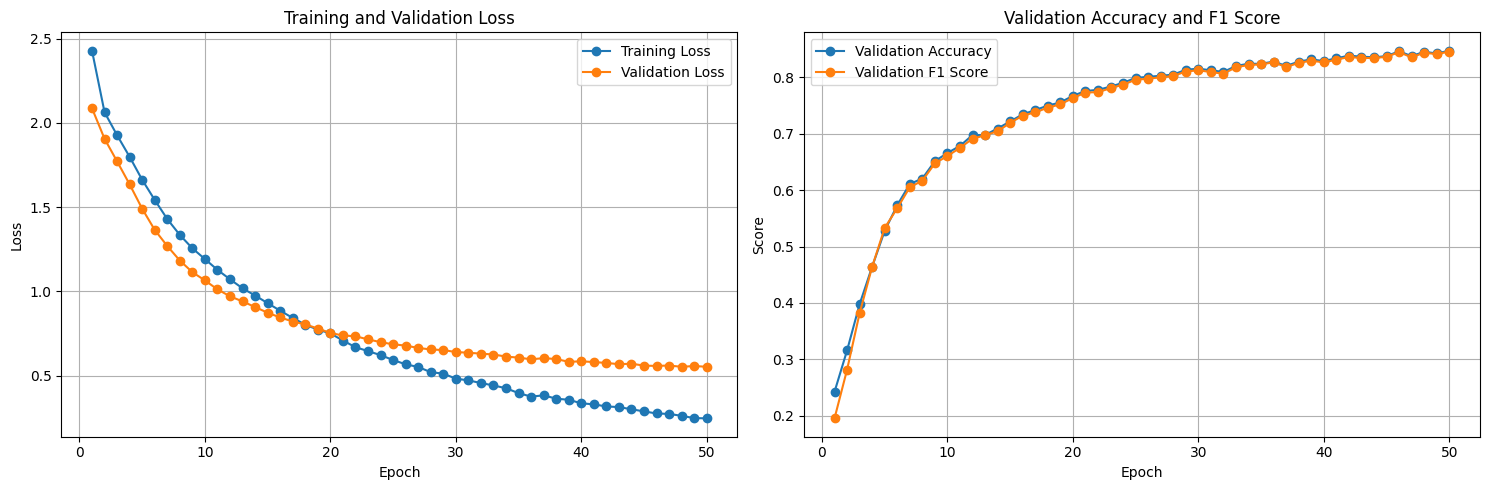

In [30]:
bert_tiny_transformer_model = TransformerClassificationModel('prajjwal1/bert-tiny', num_classes=len(topic2id))
bert_tiny_full_finetuned = train_transformer(bert_tiny_transformer_model, bert_tiny_train_loader, bert_tiny_test_loader, num_epochs=2*EPOCHS, freeze_backbone=False)

---

# Attention Maps

Analyze model attention to interpret how they focus on various question elements

In [31]:
def get_attention_map(model, input_ids, layer=0, head=0):
    outputs = model.backbone(input_ids=input_ids, output_attentions=True)
    attentions = outputs.attentions
    attention_map = attentions[layer][0, head].detach().cpu()
    return attention_map

In [32]:
def plot_attention_map(attention_map, tokens, model_name, head, ax):

    sns.heatmap(attention_map, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax)
    ax.set_title(f"{model_name}, Head {head+1}")
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Tokens")
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

In [ ]:
def draw_attention_maps_for_models(text: str, models, tokenizers, q_heads, num_tokens):
    fig, axes = plt.subplots(len(models), q_heads, figsize=(20, 18))
    if q_heads == 1:
        axes = axes.reshape(len(models), len(attention_heads))

    for model_idx, (model_name, tokenizer) in enumerate(zip(models, tokenizers)):
        model = TransformerClassificationModel(model_name, num_classes=len(topic2id))
        model.to(device)

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=num_tokens, padding="max_length")
        input_ids = inputs["input_ids"].to(device)

        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])[:num_tokens]

        num_attention_heads = model.backbone.encoder.layer[0].attention.self.num_attention_heads

        print(model_name)
        print("Num head:", num_attention_heads)

        if num_attention_heads > 3:
            attention_heads = [0, num_attention_heads//2, num_attention_heads - 1]
        else:
            attention_heads = [i for i in range(num_attention_heads)]
            
        for head_idx, head in enumerate(attention_heads):

            attention_map = get_attention_map(model, input_ids, layer=0, head=head)
            plot_attention_map(attention_map, tokens, model_name, head, axes[model_idx, head_idx])

    plt.tight_layout()

    plt.show()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

14. describe the smallest subspace of the 2 by 2 matrix space m that contains 1 0 0 1 1 0 1 0 (a) and . (b) and . 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 (c) . (d) , , . 0 0 0 0 0 1 0 1


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


tbs17/MathBERT
Num head: 12
google-bert/bert-base-uncased
Num head: 12
prajjwal1/bert-tiny
Num head: 2


IndexError: index 6 is out of bounds for dimension 1 with size 2

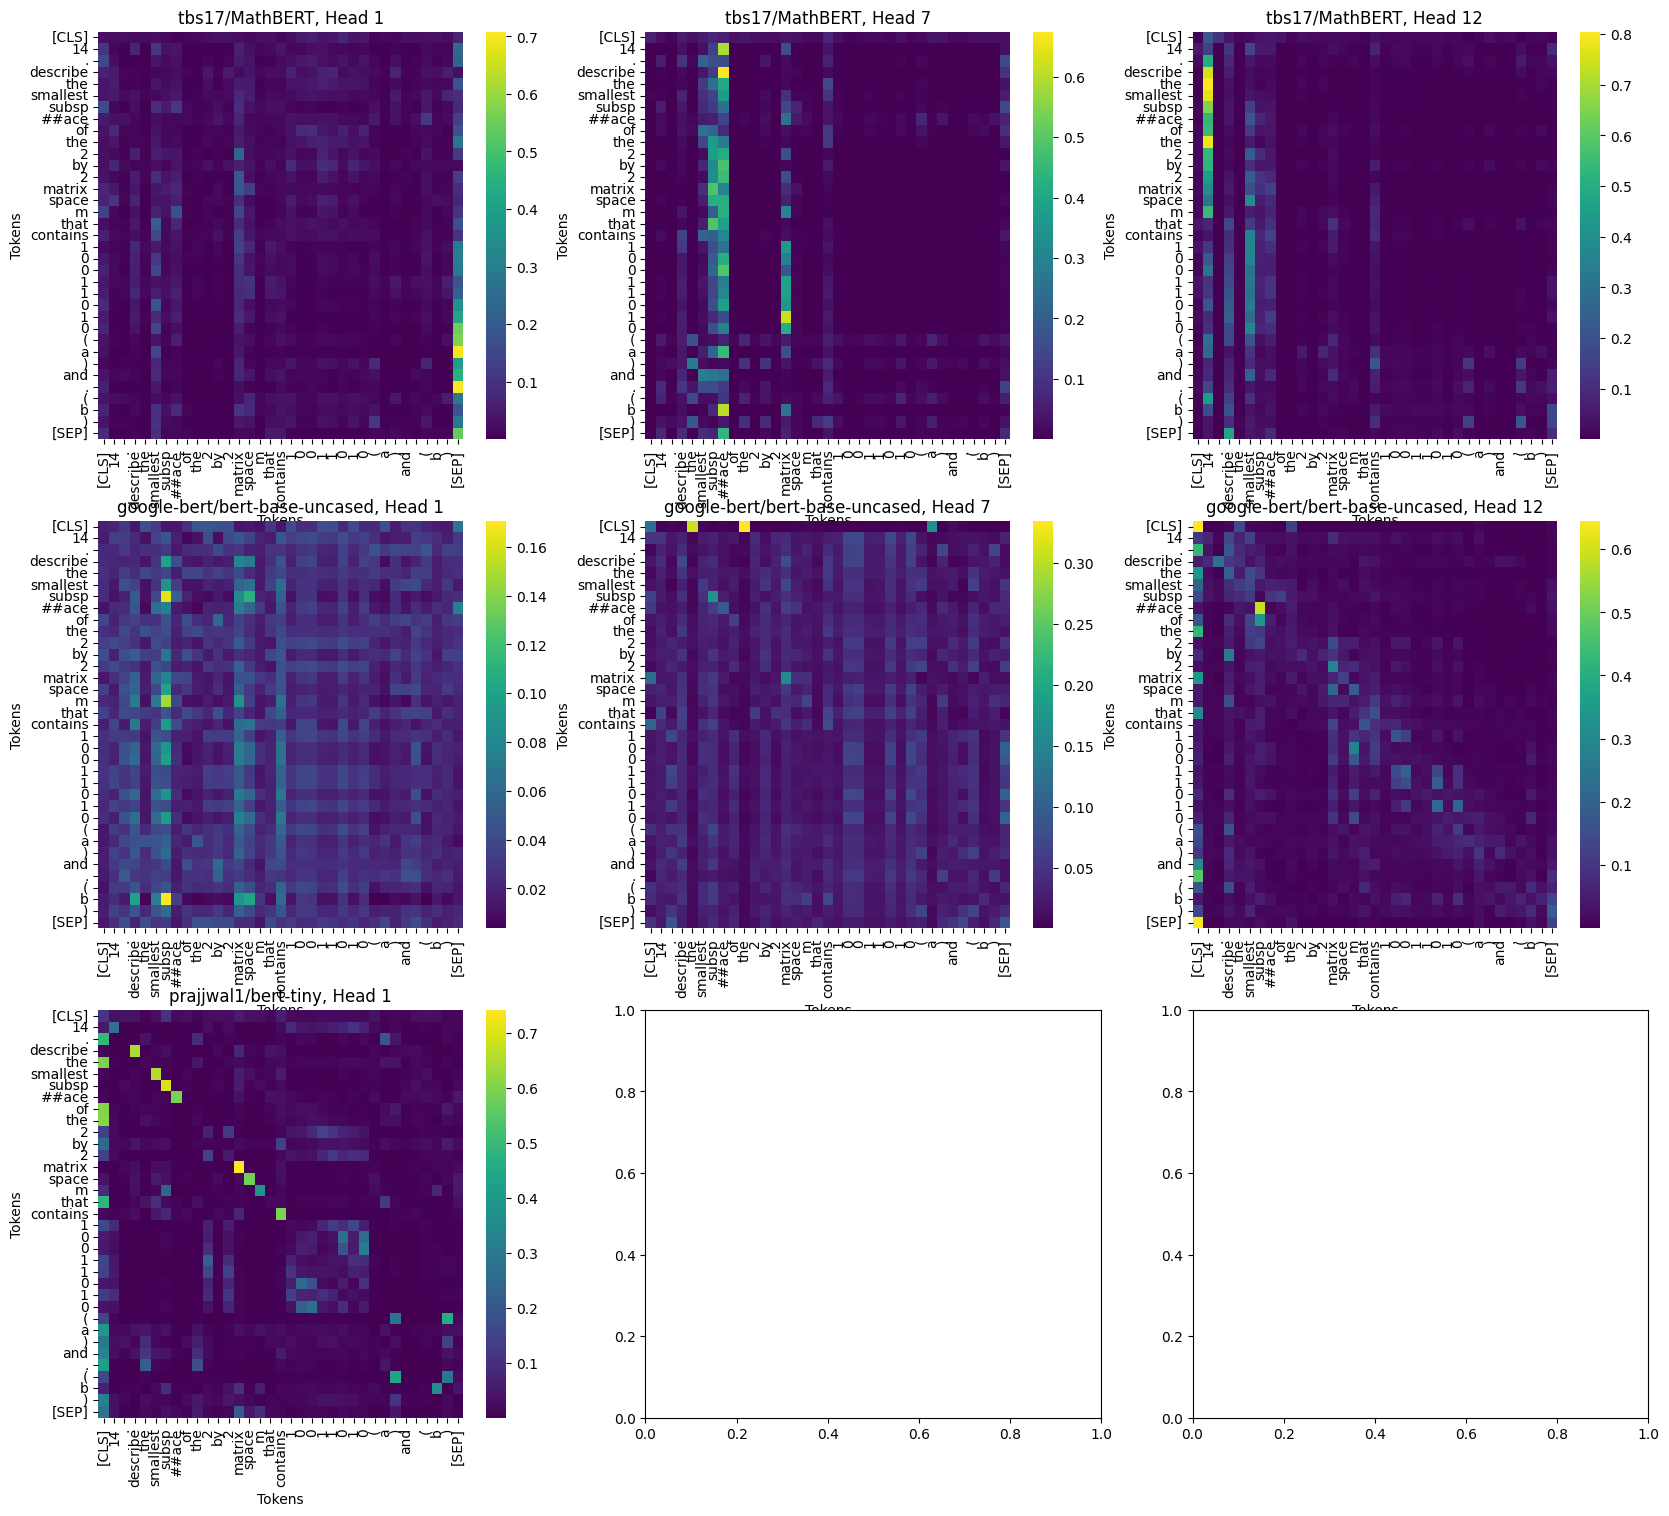

In [35]:
texts = test_dataset['text'][:3] 
for text in texts:
    print(text)

    models = ['tbs17/MathBERT', "google-bert/bert-base-uncased", "prajjwal1/bert-tiny"]
    tokenizers = [
        AutoTokenizer.from_pretrained('tbs17/MathBERT'),
        AutoTokenizer.from_pretrained("google-bert/bert-base-uncased"),
        AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
    
    ]
    draw_attention_maps_for_models(text, models, tokenizers, q_heads=3, num_tokens=35)

In [ ]:
def draw_attention_maps_for_finetuned_models(text: str, models, model_names, tokenizers, q_heads, num_tokens):
    fig, axes = plt.subplots(len(models), q_heads, figsize=(18, 15))
    if q_heads == 1:
        axes = axes.reshape(len(models), len(attention_heads))

    for model_idx, (model, tokenizer, model_name) in enumerate(zip(models, tokenizers, model_names)):
        model = model
        model.to(device)
        
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=num_tokens, padding="max_length")
        input_ids = inputs["input_ids"].to(device)

        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])[:num_tokens]
        num_attention_heads = model.backbone.encoder.layer[0].attention.self.num_attention_heads

        print(model_name)
        print("Num heads:", num_attention_heads)

        attention_heads = [0, 6, num_attention_heads - 1]

        for head_idx, head in enumerate(attention_heads):
            attention_map = get_attention_map(model, input_ids, layer=0, head=head)
            plot_attention_map(attention_map, tokens, model_name, head, axes[model_idx, head_idx])



    plt.tight_layout()
    plt.show()

In [ ]:
for text in texts:
    print(text)

    models = ['tbs17/MathBERT', "google-bert/bert-base-uncased", "prajjwal1/bert-tiny"]
    tokenizers = [
        AutoTokenizer.from_pretrained('tbs17/MathBERT'),
        AutoTokenizer.from_pretrained("google-bert/bert-base-uncased"),
        AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")    
    ]
    models_full_finetuned = [mathbert_full_finetuned, bert_base_full_finetuned, bert_tiny_full_finetuned]
    
    draw_attention_maps_for_finetuned_models(text, models_full_finetuned, models, tokenizers, q_heads=3, num_tokens=35)

---